In [1]:
import warnings
warnings.filterwarnings("ignore")
import sys
sys.path.append('../')

# Embedding

In [2]:

from models.embedding import TokenEmbedding,PositionalEmbedding
import numpy as np
import torch

In [4]:
value_embedding = TokenEmbedding(c_in = 3, 
                                 token_d_model = 96,
                                 kernel_size = 3, 
                                 stride = 1, 
                                 conv_bias=False,
                                 activation="relu",
                                 norm_type = "batch",
                                 n_conv_layers=3,
                                 in_planes=None,
                                 max_pool=False,
                                 pooling_kernel_size=3, 
                                 pooling_stride=1,
                                 pooling_padding=1).to("cpu")

In [5]:
temp_input = torch.from_numpy(np.random.rand(64,100,3)).float()
torch.onnx.export(value_embedding, temp_input, "value_embedding.onnx")

In [6]:
value_embedding.sequence_length(length       =  100, 
                                n_channels   =  3)

100

In [7]:
value_embedding(temp_input).shape

torch.Size([64, 100, 96])

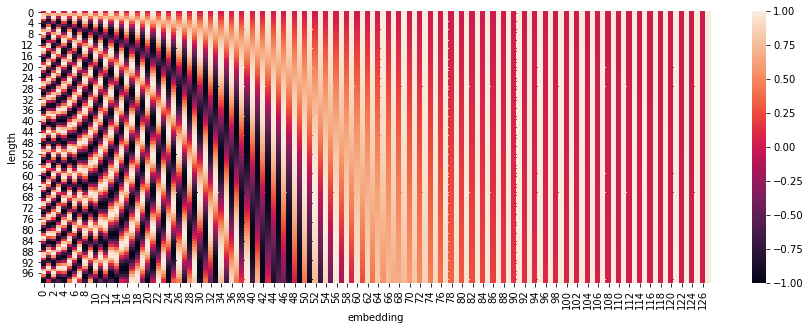

In [8]:
pos = PositionalEmbedding(128)
pos.vis_pos_heat(100)

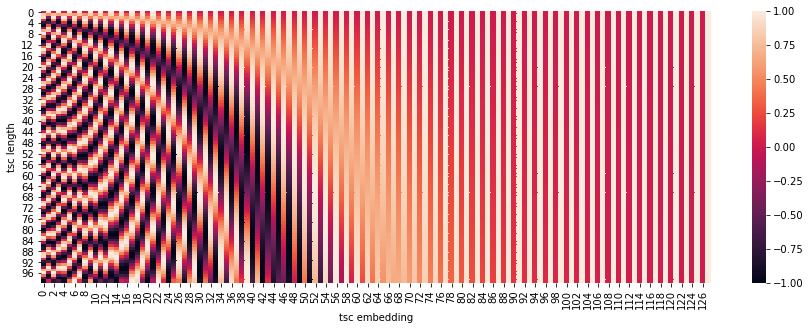

In [9]:
from models.model import TSCtransformer
import matplotlib.pyplot as plt
import seaborn as sns
tsc_heat = TSCtransformer.sinusoidal_embedding(100,128)
plt.figure(figsize=(15,5))
sns.heatmap(tsc_heat.detach().numpy()[0], linewidth=0)
plt.ylabel("tsc length")
plt.xlabel("tsc embedding")
plt.show()

# Attention

In [10]:
from models.attention import AttentionLayer, MaskAttention

In [11]:
attn = AttentionLayer(attention          = MaskAttention(mask_flag          = False, 
                                                        mask_typ           = "Triangular",
                                                        attention_dropout  = 0.1,
                                                        output_attention   = True ),
                      d_model            = 128, 
                      n_heads            = 8,
                      d_keys             = None, 
                      d_values           = None, 
                      causal_kernel_size = 3, 
                      value_kernel_size  = 1,
                      projection_dropout = 0.1)

TypeError: __init__() missing 1 required positional argument: 'input_dim'

In [14]:
x = torch.from_numpy(np.random.rand(64,100,128)).float()
new_x, attn_map = attn(x, x, x)

In [15]:
print(x.shape)
print(new_x.shape)

torch.Size([64, 100, 128])
torch.Size([64, 100, 128])


In [16]:
torch.onnx.export(attn, (x,x,x), "attn.onnx", opset_version=10)

# Encoderlayer

In [12]:
from models.encoder import EncoderLayer, ConvLayer
from models.attention import AttentionLayer, MaskAttention
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
encoder_one_layer = EncoderLayer(AttentionLayer(attention          = MaskAttention(mask_flag          = False, 
                                                                                   mask_typ           = "Triangular",
                                                                                   attention_dropout  = 0.1, 
                                                                                   output_attention   = True ),
                                                d_model            = 128, 
                                                n_heads            = 8,
                                                d_keys             = None, 
                                                d_values           = None, 
                                                causal_kernel_size = 3, 
                                                value_kernel_size  = 1,
                                                projection_dropout = 0.1),
                                 d_model             = 128,
                                 dim_feedforward     = None, 
                                 feedforward_dropout = 0.1,
                                 activation          = "gelu",
                                 norm_type           = "layer",
                                 forward_kernel_size = 3)

TypeError: __init__() missing 1 required positional argument: 'input_dim'

In [14]:
x = torch.from_numpy(np.random.rand(64,100,128)).float()
new_x, attn_map = encoder_one_layer(x)

NameError: name 'encoder_one_layer' is not defined

In [15]:
torch.onnx.export(encoder_one_layer, x, "encoder_one_layer.onnx", opset_version=10)

NameError: name 'encoder_one_layer' is not defined

In [7]:
attn_map.shape

torch.Size([64, 8, 100, 100])

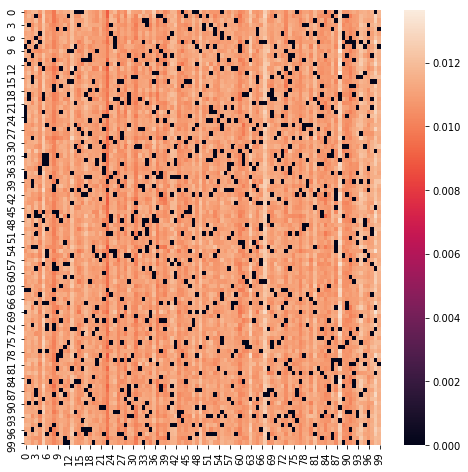

In [10]:
plt.figure(figsize=(8,8))
sns.heatmap(attn_map[0].detach().numpy()[0], linewidth=0)
plt.show()

# ConvLayer

In [2]:
import torch
from models.encoder import EncoderLayer, ConvLayer
import numpy as np
conv_one_layer = ConvLayer( c_in        = 128, 
                           c_out           =128,  
                           conv_norm       = "batch", 
                           conv_activation = "gelu" )

In [4]:
x = torch.from_numpy(np.random.rand(64,100,128)).float()
x_out = conv_one_layer(x)

In [5]:
x.shape

torch.Size([64, 100, 128])

In [6]:
x_out.shape

torch.Size([64, 50, 128])

# Encoder

In [9]:
from models.encoder import EncoderLayer, ConvLayer, Encoder
from models.attention import AttentionLayer, MaskAttention
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import numpy as np

In [10]:
distil = True
encoder = Encoder([EncoderLayer(AttentionLayer(attention          = MaskAttention(mask_flag          = False, 
                                                                                  mask_typ           = "Triangular",
                                                                                  attention_dropout  = 0.1, 
                                                                                  output_attention   = True),
                                               d_model            = 128, 
                                               n_heads            = 8,
                                               d_keys             = None, 
                                               d_values           = None, 
                                               causal_kernel_size = 3, 
                                               value_kernel_size  = 1,
                                               projection_dropout = 0.1),
                                d_model             = 128,
                                dim_feedforward     = None, 
                                feedforward_dropout = 0.1,
                                activation          = "gelu",
                                norm_type           = "batch",
                                forward_kernel_size = 3) for l in range(2)],
                  [ConvLayer(c_in            = 128, 
                             c_out           = 128,  
                             conv_norm       = "batch", 
                             conv_activation = "relu" ) for l in range(2-1)] if distil else None
                 )

In [11]:
x = torch.from_numpy(np.random.rand(64,100,128)).float()
x_out,attns = encoder(x)

In [12]:
x.shape

torch.Size([64, 100, 128])

In [13]:
x_out.shape

torch.Size([64, 50, 128])

In [14]:
torch.onnx.export(encoder, x, "encoder.onnx", opset_version=10)

# build the model

In [13]:
from models.model import TSCtransformer
import torch
import numpy as np
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__
args = dotdict()    
# ======== model parameters  ========

# input information
args.c_in                       =  1 # it depends on the dataset
args.input_length               =  100 # it depends on the dataset
args.num_classes                =  2
# embedding 

args.token_d_model              =  64
args.token_kernel_size          =  3
args.token_stride               =  1
args.token_conv_bias            =  False
args.token_activation           =  "relu"
args.token_norm                 =  "layer"
args.token_n_layers             =  2
args.token_in_planes            =  32
args.token_max_pool             =  False
args.token_pool_kernel_size     =  3
args.token_pool_stride          =  1
args.token_pool_pad             =  1
args.positional_embedding       = "learnable"   #None , "learnable" , "sinus"
args.input_embedding_dropout    = 0.1

# Encoder
args.e_layers                   = 4
args.distil                     = True

args.mask_flag                  = False
args.mask_typ                   = "Triangular"
args.attention_dropout          = 0.1   # attention map 也就是score的drop
args.output_attention           = True

args.n_heads                    = 8
args.d_keys                     = None
args.d_values                   = None
args.causal_kernel_size         = 3
args.value_kernel_size          = 1
args.projection_dropout         = 1

args.feedforward_dim            = None
args.feedforward_dropout        = 0.1
args.feedforward_activation     = "relu"
args.feedforward_norm_type      = "layer"
args.forward_kernel_size        = 3

args.conv_norm                  = "layer"
args.conv_activation            = "relu"


model = TSCtransformer(args)



In [14]:
x = torch.from_numpy(np.random.rand(64,args.input_length,args.c_in)).float()
out, attns = model(x)

In [15]:
torch.onnx.export(model, x, "model.onnx", opset_version=10)

In [16]:
print(np.sum([para.numel() for para in model.parameters()]))

578083


# Dataloader UCR

In [17]:
from models.dataloader import data_loader_dict,plot_dict#UCR_TSC_DATA_UNIVARIATE,UCI_HAR_DATA,plot_the_uci_har_data_set,plot_the_ucr_uni_data_set

ImportError: cannot import name 'load_data' from 'sktime.utils' (D:\anaconda\lib\site-packages\sktime\utils\__init__.py)

In [3]:
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__
args = dotdict()    

args.root_path    = r"..\..\data\UCR TS\Univariate_arff"
args.data_loader  = "ucr_uni"
args.data_name    = "Plane"
args.difference   =  False
args.augmentation =  False
args.normalizer   =  False

In [4]:
train_data = data_loader_dict[args.data_loader](args, "train")
test_data  = data_loader_dict[args.data_loader](args, "test")

load the data  ..\..\data\UCR TS\Univariate_arff   Plane
the shape of train is :  (105, 144, 1)
The number of classes is :  7
load the data  ..\..\data\UCR TS\Univariate_arff   Plane
the shape of test is :  (105, 144, 1)
The number of classes is :  7


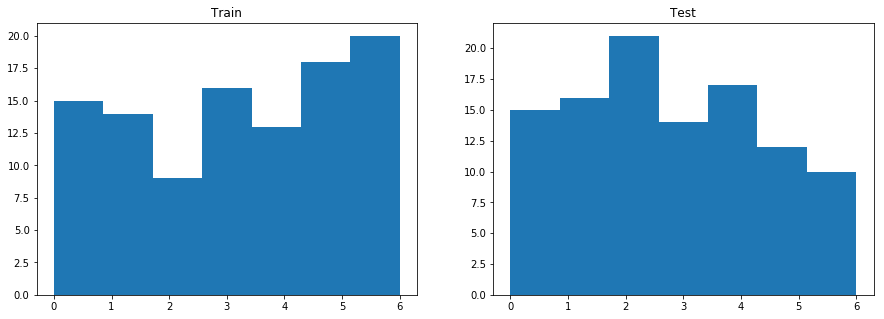

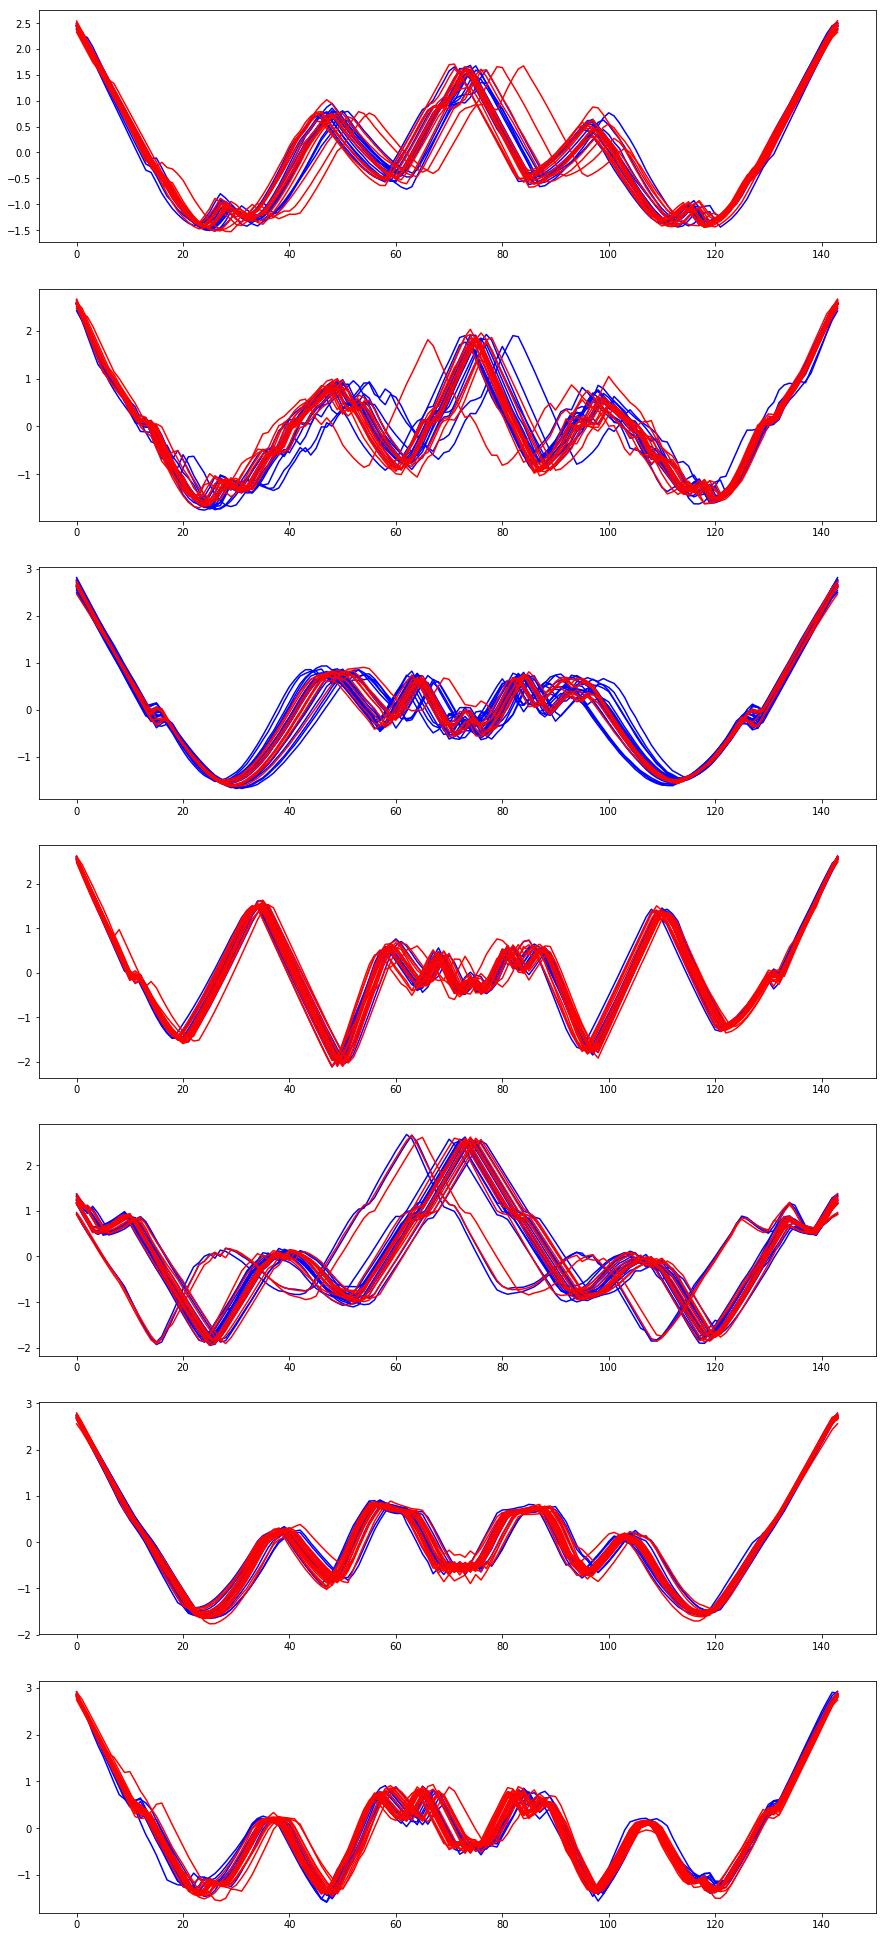

In [5]:
plot_dict[args.data_loader](train_data.data_x,train_data.data_y,test_data.data_x,test_data.data_y)

In [6]:
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__
args = dotdict()    

args.root_path    = "../../data/Activity Recognition/data/UCI HAR Dataset/UCIHAR/"
args.data_loader  = "uci_har"
args.data_name    = "UCI HAR"
args.difference   =  False
args.augmentation =  False
args.normalizer   =  False

train_data = data_loader_dict[args.data_loader](args, "train")
test_data  = data_loader_dict[args.data_loader](args, "test")

load the data  ../../data/Activity Recognition/data/UCI HAR Dataset/UCIHAR/   UCI HAR
Train data number :  7352
The number of classes is :  6
The input_length  is :  128
The channel_in is :  8
load the data  ../../data/Activity Recognition/data/UCI HAR Dataset/UCIHAR/   UCI HAR
Test data number :  2947
The number of classes is :  6


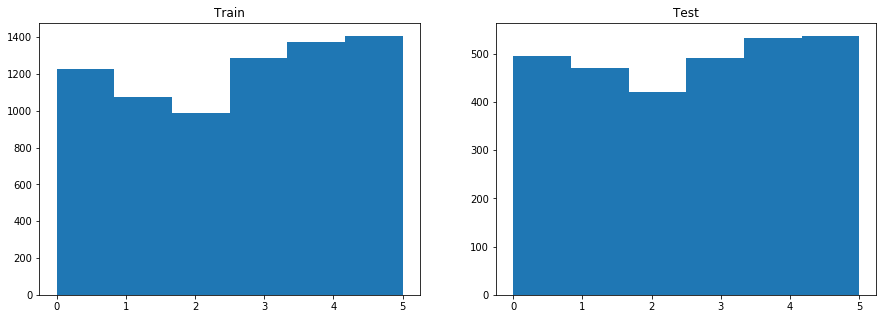

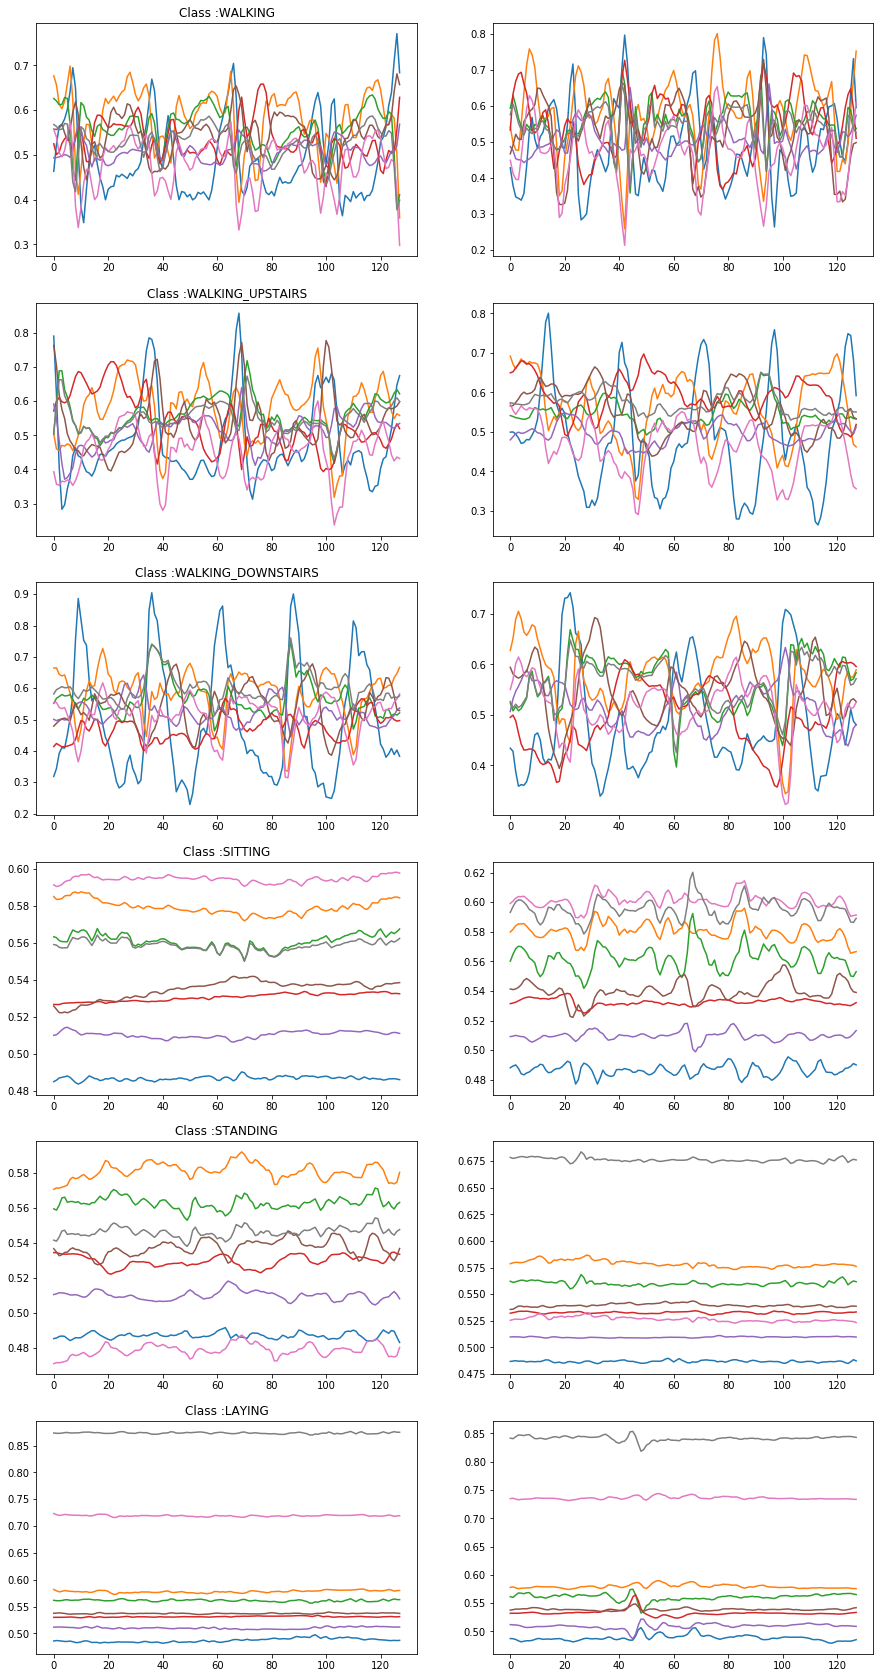

In [7]:
plot_dict[args.data_loader](train_data.data_x,train_data.data_y,test_data.data_x,test_data.data_y)

# Experiment

In [2]:
from models.experiment import Exp
from models.dataloader import UCR_TSC_DATA_UNIVARIATE,plot_the_data_set
import torch

In [36]:
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__
args = dotdict()    

args.root_path    = r"F:\AutoTS\ECMLTimeSeriesClassification\datasets\Univariate_arff"
args.data_name    = "Plane"
args.difference   =  False
args.augmentation =  False
args.normalizer   =  False

train_data = UCR_TSC_DATA_UNIVARIATE(args, "train")
args.dataloader                 = "ucr_univariante"
# input information
args.c_in                       =  train_data.channel_in # it depends on the dataset
args.input_length               =  train_data.input_length # it depends on the dataset
args.num_classes                =  train_data.nb_classes

# embedding 
args.token_d_model              =  16
args.token_kernel_size          =  3
args.token_stride               =  1
args.token_conv_bias            =  False
args.token_activation           =  "relu"
args.token_norm                 =  "layer"
args.token_n_layers             =  3
args.token_in_planes            =  8
args.token_max_pool             =  False
args.token_pool_kernel_size     =  3
args.token_pool_stride          =  1
args.token_pool_pad             =  1
args.positional_embedding       = None   #None , "learnable" , "sinus"
args.input_embedding_dropout    = 0

# Encoder
args.e_layers                   = 8
args.distil                     = True

args.mask_flag                  = False
args.mask_typ                   = "Triangular"
args.attention_dropout          = 0   # attention map 也就是score的drop
args.output_attention           = True

args.n_heads                    = 5
args.d_keys                     = None
args.d_values                   = None
args.causal_kernel_size         = 3
args.value_kernel_size          = 1
args.projection_dropout         = 1

args.feedforward_dim            = None
args.feedforward_dropout        = 0
args.feedforward_activation     = "relu"
args.feedforward_norm_type      = "layer"
args.forward_kernel_size        = 3

args.conv_norm                  = "layer"
args.conv_activation            = "relu"


# training setting 
args.train_epochs           = 10000

args.learning_rate          = 0.0001  
args.learning_rate_patience = 80
args.learning_rate_factor   = 0.5


args.early_stop_patience    = 500

args.use_gpu                = True if torch.cuda.is_available() else False
args.gpu                    = 0
args.use_multi_gpu          = False

args.optimizer              = "Adam"
args.criterion              = "CrossEntropy"
args.batch_size             =  32



load the data  F:\AutoTS\ECMLTimeSeriesClassification\datasets\Univariate_arff   Plane
the shape of train is :  (105, 144, 1)
The number of classes is :  7


In [37]:
exp = Exp(args)

Use CPU
Build the model!


In [38]:
import numpy as np
print(np.sum([para.numel() for para in exp.model.parameters()]))

74968


In [39]:
save_path = args.data_name 
exp.train(save_path)

load the data  F:\AutoTS\ECMLTimeSeriesClassification\datasets\Univariate_arff   Plane
the shape of train is :  (105, 144, 1)
The number of classes is :  7
load the data  F:\AutoTS\ECMLTimeSeriesClassification\datasets\Univariate_arff   Plane
the shape of test is :  (105, 144, 1)
The number of classes is :  7
Epoch: 1 cost time: 0.5071132183074951
Epoch: 1, Steps: 4 | Train Loss: 1.9739350 Train Accuracy 0.0380952 Vali Loss: 2.0206603 Vali Accuracy: 0.0190476
Validation loss decreased (inf --> 2.020660).  Saving model ...
Epoch: 2 cost time: 0.5141308307647705
Epoch: 2, Steps: 4 | Train Loss: 1.7708272 Train Accuracy 0.0190476 Vali Loss: 2.1527332 Vali Accuracy: 0.0190476
EarlyStopping counter: 1 out of 500
Learning rate adjusting counter: 2 out of 80
Epoch: 3 cost time: 0.5001120567321777
Epoch: 3, Steps: 4 | Train Loss: 1.6539088 Train Accuracy 0.0190476 Vali Loss: 2.2042435 Vali Accuracy: 0.0380952
EarlyStopping counter: 2 out of 500
Learning rate adjusting counter: 3 out of 80
Epoc

Epoch: 35 cost time: 0.5061135292053223
Epoch: 35, Steps: 4 | Train Loss: 0.6373979 Train Accuracy 0.2476190 Vali Loss: 2.2168299 Vali Accuracy: 0.1142857
EarlyStopping counter: 34 out of 500
Learning rate adjusting counter: 35 out of 80
Epoch: 36 cost time: 0.49511075019836426
Epoch: 36, Steps: 4 | Train Loss: 0.6321114 Train Accuracy 0.2476190 Vali Loss: 2.2193966 Vali Accuracy: 0.1047619
EarlyStopping counter: 35 out of 500
Learning rate adjusting counter: 36 out of 80
Epoch: 37 cost time: 0.4991109371185303
Epoch: 37, Steps: 4 | Train Loss: 0.6159114 Train Accuracy 0.2476190 Vali Loss: 2.2189352 Vali Accuracy: 0.1238095
EarlyStopping counter: 36 out of 500
Learning rate adjusting counter: 37 out of 80
Epoch: 38 cost time: 0.4811077117919922
Epoch: 38, Steps: 4 | Train Loss: 0.6092462 Train Accuracy 0.2476190 Vali Loss: 2.2186261 Vali Accuracy: 0.1238095
EarlyStopping counter: 37 out of 500
Learning rate adjusting counter: 38 out of 80
Epoch: 39 cost time: 0.4921104907989502
Epoch: 

Epoch: 70 cost time: 0.4991128444671631
Epoch: 70, Steps: 4 | Train Loss: 0.4594074 Train Accuracy 0.2190476 Vali Loss: 2.2750924 Vali Accuracy: 0.1714286
EarlyStopping counter: 69 out of 500
Learning rate adjusting counter: 70 out of 80
Epoch: 71 cost time: 0.4991116523742676
Epoch: 71, Steps: 4 | Train Loss: 0.4538491 Train Accuracy 0.2380952 Vali Loss: 2.2776834 Vali Accuracy: 0.1619048
EarlyStopping counter: 70 out of 500
Learning rate adjusting counter: 71 out of 80
Epoch: 72 cost time: 0.49310970306396484
Epoch: 72, Steps: 4 | Train Loss: 0.4516491 Train Accuracy 0.2380952 Vali Loss: 2.2789834 Vali Accuracy: 0.1619048
EarlyStopping counter: 71 out of 500
Learning rate adjusting counter: 72 out of 80
Epoch: 73 cost time: 0.5031130313873291
Epoch: 73, Steps: 4 | Train Loss: 0.4526561 Train Accuracy 0.2190476 Vali Loss: 2.2767197 Vali Accuracy: 0.1619048
EarlyStopping counter: 72 out of 500
Learning rate adjusting counter: 73 out of 80
Epoch: 74 cost time: 0.4981114864349365
Epoch: 

Epoch: 105 cost time: 0.5131151676177979
Epoch: 105, Steps: 4 | Train Loss: 0.3934675 Train Accuracy 0.2380952 Vali Loss: 2.3130233 Vali Accuracy: 0.1809524
EarlyStopping counter: 104 out of 500
Learning rate adjusting counter: 25 out of 80
Epoch: 106 cost time: 0.49711012840270996
Epoch: 106, Steps: 4 | Train Loss: 0.3924439 Train Accuracy 0.2476190 Vali Loss: 2.3134607 Vali Accuracy: 0.1809524
EarlyStopping counter: 105 out of 500
Learning rate adjusting counter: 26 out of 80
Epoch: 107 cost time: 0.5251176357269287
Epoch: 107, Steps: 4 | Train Loss: 0.3987062 Train Accuracy 0.2476190 Vali Loss: 2.3142666 Vali Accuracy: 0.1904762
EarlyStopping counter: 106 out of 500
Learning rate adjusting counter: 27 out of 80
Epoch: 108 cost time: 0.5331206321716309
Epoch: 108, Steps: 4 | Train Loss: 0.3929389 Train Accuracy 0.2476190 Vali Loss: 2.3154393 Vali Accuracy: 0.1809524
EarlyStopping counter: 107 out of 500
Learning rate adjusting counter: 28 out of 80
Epoch: 109 cost time: 0.53311872482

Epoch: 139 cost time: 0.49511146545410156
Epoch: 139, Steps: 4 | Train Loss: 0.3577768 Train Accuracy 0.2571429 Vali Loss: 2.3385792 Vali Accuracy: 0.2095238
EarlyStopping counter: 138 out of 500
Learning rate adjusting counter: 59 out of 80
Epoch: 140 cost time: 0.48210859298706055
Epoch: 140, Steps: 4 | Train Loss: 0.3573345 Train Accuracy 0.2571429 Vali Loss: 2.3399318 Vali Accuracy: 0.2095238
EarlyStopping counter: 139 out of 500
Learning rate adjusting counter: 60 out of 80
Epoch: 141 cost time: 0.49511051177978516
Epoch: 141, Steps: 4 | Train Loss: 0.3544351 Train Accuracy 0.2476190 Vali Loss: 2.3415333 Vali Accuracy: 0.2095238
EarlyStopping counter: 140 out of 500
Learning rate adjusting counter: 61 out of 80
Epoch: 142 cost time: 0.4791073799133301
Epoch: 142, Steps: 4 | Train Loss: 0.3561037 Train Accuracy 0.2571429 Vali Loss: 2.3419149 Vali Accuracy: 0.2095238
EarlyStopping counter: 141 out of 500
Learning rate adjusting counter: 62 out of 80
Epoch: 143 cost time: 0.494111061

Epoch: 173 cost time: 0.5341198444366455
Epoch: 173, Steps: 4 | Train Loss: 0.3296476 Train Accuracy 0.2666667 Vali Loss: 2.3631141 Vali Accuracy: 0.2190476
EarlyStopping counter: 172 out of 500
Learning rate adjusting counter: 13 out of 80
Epoch: 174 cost time: 0.4851088523864746
Epoch: 174, Steps: 4 | Train Loss: 0.3364614 Train Accuracy 0.2666667 Vali Loss: 2.3629518 Vali Accuracy: 0.2190476
EarlyStopping counter: 173 out of 500
Learning rate adjusting counter: 14 out of 80
Epoch: 175 cost time: 0.5091140270233154
Epoch: 175, Steps: 4 | Train Loss: 0.3307102 Train Accuracy 0.2666667 Vali Loss: 2.3632389 Vali Accuracy: 0.2190476
EarlyStopping counter: 174 out of 500
Learning rate adjusting counter: 15 out of 80
Epoch: 176 cost time: 0.49511003494262695
Epoch: 176, Steps: 4 | Train Loss: 0.3312206 Train Accuracy 0.2666667 Vali Loss: 2.3630161 Vali Accuracy: 0.2190476
EarlyStopping counter: 175 out of 500
Learning rate adjusting counter: 16 out of 80
Epoch: 177 cost time: 0.51711559295

Epoch: 207 cost time: 0.500112771987915
Epoch: 207, Steps: 4 | Train Loss: 0.3226314 Train Accuracy 0.2761905 Vali Loss: 2.3746091 Vali Accuracy: 0.2190476
EarlyStopping counter: 206 out of 500
Learning rate adjusting counter: 47 out of 80
Epoch: 208 cost time: 0.4881103038787842
Epoch: 208, Steps: 4 | Train Loss: 0.3179862 Train Accuracy 0.2761905 Vali Loss: 2.3753202 Vali Accuracy: 0.2190476
EarlyStopping counter: 207 out of 500
Learning rate adjusting counter: 48 out of 80
Epoch: 209 cost time: 0.5021114349365234
Epoch: 209, Steps: 4 | Train Loss: 0.3197195 Train Accuracy 0.2761905 Vali Loss: 2.3761096 Vali Accuracy: 0.2190476
EarlyStopping counter: 208 out of 500
Learning rate adjusting counter: 49 out of 80
Epoch: 210 cost time: 0.49511122703552246
Epoch: 210, Steps: 4 | Train Loss: 0.3137163 Train Accuracy 0.2761905 Vali Loss: 2.3773480 Vali Accuracy: 0.2190476
EarlyStopping counter: 209 out of 500
Learning rate adjusting counter: 50 out of 80
Epoch: 211 cost time: 0.483108282089

Epoch: 241 cost time: 0.4811084270477295
Epoch: 241, Steps: 4 | Train Loss: 0.3027281 Train Accuracy 0.2761905 Vali Loss: 2.3903016 Vali Accuracy: 0.2190476
EarlyStopping counter: 240 out of 500
Learning rate adjusting counter: 1 out of 80
Epoch: 242 cost time: 0.5071136951446533
Epoch: 242, Steps: 4 | Train Loss: 0.3025892 Train Accuracy 0.2761905 Vali Loss: 2.3904933 Vali Accuracy: 0.2190476
EarlyStopping counter: 241 out of 500
Learning rate adjusting counter: 2 out of 80
Epoch: 243 cost time: 0.48610949516296387
Epoch: 243, Steps: 4 | Train Loss: 0.3010451 Train Accuracy 0.2761905 Vali Loss: 2.3902821 Vali Accuracy: 0.2190476
EarlyStopping counter: 242 out of 500
Learning rate adjusting counter: 3 out of 80
Epoch: 244 cost time: 0.49811220169067383
Epoch: 244, Steps: 4 | Train Loss: 0.3105270 Train Accuracy 0.2761905 Vali Loss: 2.3902129 Vali Accuracy: 0.2190476
EarlyStopping counter: 243 out of 500
Learning rate adjusting counter: 4 out of 80
Epoch: 245 cost time: 0.48910951614379

Epoch: 275 cost time: 0.5011124610900879
Epoch: 275, Steps: 4 | Train Loss: 0.2957646 Train Accuracy 0.2761905 Vali Loss: 2.3947618 Vali Accuracy: 0.2285714
EarlyStopping counter: 274 out of 500
Learning rate adjusting counter: 35 out of 80
Epoch: 276 cost time: 0.48010754585266113
Epoch: 276, Steps: 4 | Train Loss: 0.2959750 Train Accuracy 0.2761905 Vali Loss: 2.3956467 Vali Accuracy: 0.2285714
EarlyStopping counter: 275 out of 500
Learning rate adjusting counter: 36 out of 80
Epoch: 277 cost time: 0.48410797119140625
Epoch: 277, Steps: 4 | Train Loss: 0.3041360 Train Accuracy 0.2761905 Vali Loss: 2.3962647 Vali Accuracy: 0.2285714
EarlyStopping counter: 276 out of 500
Learning rate adjusting counter: 37 out of 80
Epoch: 278 cost time: 0.47310614585876465
Epoch: 278, Steps: 4 | Train Loss: 0.2921542 Train Accuracy 0.2761905 Vali Loss: 2.3965835 Vali Accuracy: 0.2285714
EarlyStopping counter: 277 out of 500
Learning rate adjusting counter: 38 out of 80
Epoch: 279 cost time: 0.481107711

Epoch: 309 cost time: 0.48910999298095703
Epoch: 309, Steps: 4 | Train Loss: 0.2926121 Train Accuracy 0.2761905 Vali Loss: 2.4043185 Vali Accuracy: 0.2380952
EarlyStopping counter: 308 out of 500
Learning rate adjusting counter: 69 out of 80
Epoch: 310 cost time: 0.49711132049560547
Epoch: 310, Steps: 4 | Train Loss: 0.2877395 Train Accuracy 0.2761905 Vali Loss: 2.4046218 Vali Accuracy: 0.2380952
EarlyStopping counter: 309 out of 500
Learning rate adjusting counter: 70 out of 80
Epoch: 311 cost time: 0.48410773277282715
Epoch: 311, Steps: 4 | Train Loss: 0.2902996 Train Accuracy 0.2761905 Vali Loss: 2.4049868 Vali Accuracy: 0.2380952
EarlyStopping counter: 310 out of 500
Learning rate adjusting counter: 71 out of 80
Epoch: 312 cost time: 0.4891088008880615
Epoch: 312, Steps: 4 | Train Loss: 0.2934478 Train Accuracy 0.2761905 Vali Loss: 2.4057367 Vali Accuracy: 0.2380952
EarlyStopping counter: 311 out of 500
Learning rate adjusting counter: 72 out of 80
Epoch: 313 cost time: 0.477108478

Epoch: 343 cost time: 0.48210811614990234
Epoch: 343, Steps: 4 | Train Loss: 0.2892473 Train Accuracy 0.2761905 Vali Loss: 2.4076365 Vali Accuracy: 0.2380952
EarlyStopping counter: 342 out of 500
Learning rate adjusting counter: 23 out of 80
Epoch: 344 cost time: 0.4921109676361084
Epoch: 344, Steps: 4 | Train Loss: 0.2866934 Train Accuracy 0.2761905 Vali Loss: 2.4083681 Vali Accuracy: 0.2380952
EarlyStopping counter: 343 out of 500
Learning rate adjusting counter: 24 out of 80
Epoch: 345 cost time: 0.49311017990112305
Epoch: 345, Steps: 4 | Train Loss: 0.2847563 Train Accuracy 0.2761905 Vali Loss: 2.4089301 Vali Accuracy: 0.2380952
EarlyStopping counter: 344 out of 500
Learning rate adjusting counter: 25 out of 80
Epoch: 346 cost time: 0.500112771987915
Epoch: 346, Steps: 4 | Train Loss: 0.2808945 Train Accuracy 0.2761905 Vali Loss: 2.4084946 Vali Accuracy: 0.2380952
EarlyStopping counter: 345 out of 500
Learning rate adjusting counter: 26 out of 80
Epoch: 347 cost time: 0.49411106109

Epoch: 377 cost time: 0.4981117248535156
Epoch: 377, Steps: 4 | Train Loss: 0.2822336 Train Accuracy 0.2857143 Vali Loss: 2.4114773 Vali Accuracy: 0.2380952
EarlyStopping counter: 376 out of 500
Learning rate adjusting counter: 57 out of 80
Epoch: 378 cost time: 0.4721088409423828
Epoch: 378, Steps: 4 | Train Loss: 0.2812858 Train Accuracy 0.2761905 Vali Loss: 2.4121555 Vali Accuracy: 0.2380952
EarlyStopping counter: 377 out of 500
Learning rate adjusting counter: 58 out of 80
Epoch: 379 cost time: 0.5061130523681641
Epoch: 379, Steps: 4 | Train Loss: 0.2789669 Train Accuracy 0.2857143 Vali Loss: 2.4118852 Vali Accuracy: 0.2380952
EarlyStopping counter: 378 out of 500
Learning rate adjusting counter: 59 out of 80
Epoch: 380 cost time: 0.4891090393066406
Epoch: 380, Steps: 4 | Train Loss: 0.2804451 Train Accuracy 0.2857143 Vali Loss: 2.4118583 Vali Accuracy: 0.2380952
EarlyStopping counter: 379 out of 500
Learning rate adjusting counter: 60 out of 80
Epoch: 381 cost time: 0.483108043670

Epoch: 411 cost time: 0.47710633277893066
Epoch: 411, Steps: 4 | Train Loss: 0.2793192 Train Accuracy 0.2857143 Vali Loss: 2.4148606 Vali Accuracy: 0.2380952
EarlyStopping counter: 410 out of 500
Learning rate adjusting counter: 11 out of 80
Epoch: 412 cost time: 0.4831082820892334
Epoch: 412, Steps: 4 | Train Loss: 0.2774645 Train Accuracy 0.2857143 Vali Loss: 2.4144967 Vali Accuracy: 0.2380952
EarlyStopping counter: 411 out of 500
Learning rate adjusting counter: 12 out of 80
Epoch: 413 cost time: 0.48210787773132324
Epoch: 413, Steps: 4 | Train Loss: 0.2827995 Train Accuracy 0.2761905 Vali Loss: 2.4150102 Vali Accuracy: 0.2380952
EarlyStopping counter: 412 out of 500
Learning rate adjusting counter: 13 out of 80
Epoch: 414 cost time: 0.4741065502166748
Epoch: 414, Steps: 4 | Train Loss: 0.2782792 Train Accuracy 0.2761905 Vali Loss: 2.4147689 Vali Accuracy: 0.2380952
EarlyStopping counter: 413 out of 500
Learning rate adjusting counter: 14 out of 80
Epoch: 415 cost time: 0.5011122226

Epoch: 445 cost time: 0.5121142864227295
Epoch: 445, Steps: 4 | Train Loss: 0.2797254 Train Accuracy 0.2857143 Vali Loss: 2.4161662 Vali Accuracy: 0.2380952
EarlyStopping counter: 444 out of 500
Learning rate adjusting counter: 45 out of 80
Epoch: 446 cost time: 0.4781067371368408
Epoch: 446, Steps: 4 | Train Loss: 0.2761346 Train Accuracy 0.2857143 Vali Loss: 2.4165423 Vali Accuracy: 0.2380952
EarlyStopping counter: 445 out of 500
Learning rate adjusting counter: 46 out of 80
Epoch: 447 cost time: 0.46810460090637207
Epoch: 447, Steps: 4 | Train Loss: 0.2845810 Train Accuracy 0.2761905 Vali Loss: 2.4179180 Vali Accuracy: 0.2380952
EarlyStopping counter: 446 out of 500
Learning rate adjusting counter: 47 out of 80
Epoch: 448 cost time: 0.4981112480163574
Epoch: 448, Steps: 4 | Train Loss: 0.2757842 Train Accuracy 0.2857143 Vali Loss: 2.4181995 Vali Accuracy: 0.2476190
EarlyStopping counter: 447 out of 500
Learning rate adjusting counter: 48 out of 80
Epoch: 449 cost time: 0.47410655021

Epoch: 479 cost time: 0.48410987854003906
Epoch: 479, Steps: 4 | Train Loss: 0.2749270 Train Accuracy 0.2857143 Vali Loss: 2.4190439 Vali Accuracy: 0.2476190
EarlyStopping counter: 478 out of 500
Learning rate adjusting counter: 79 out of 80
Epoch: 480 cost time: 0.46610474586486816
Epoch: 480, Steps: 4 | Train Loss: 0.2770834 Train Accuracy 0.2857143 Vali Loss: 2.4195300 Vali Accuracy: 0.2476190
EarlyStopping counter: 479 out of 500
Learning rate adjusting counter: 80 out of 80
Updating learning rate to 1.5625e-06
Epoch: 481 cost time: 0.4941098690032959
Epoch: 481, Steps: 4 | Train Loss: 0.2733381 Train Accuracy 0.2857143 Vali Loss: 2.4188940 Vali Accuracy: 0.2476190
EarlyStopping counter: 480 out of 500
Learning rate adjusting counter: 1 out of 80
Epoch: 482 cost time: 0.5001118183135986
Epoch: 482, Steps: 4 | Train Loss: 0.2773883 Train Accuracy 0.2857143 Vali Loss: 2.4196814 Vali Accuracy: 0.2476190
EarlyStopping counter: 481 out of 500
Learning rate adjusting counter: 2 out of 80

In [ ]:
https://github.com/SHI-Labs/Compact-Transformers/blob/f09d1d70aca1607ff181f24045343793535283cb/main.py
https://github.com/SHI-Labs/Compact-Transformers/blob/f09d1d70aca1607ff181f24045343793535283cb/main.py
https://github.com/lucidrains/vit-pytorch/tree/6e1be11517aa653647f6c50615e5fb2984e5ed2c
https://github.com/zhouhaoyi/Informer2020/blob/main/models/encoder.py
https://www.ijcai.org/Proceedings/2019/0431.pdf
https://github.com/hfawaz/InceptionTime/blob/master/main.py
    
    
    https://github.com/penhunt/full-quantization-DNN
        https://github.com/itayhubara/BinaryNet.pytorch/blob/b99870af6e73992896ab5db5ea26b83d2adb1201/models/binarized_modules.py#L87
            https://link.springer.com/article/10.1007/s00371-021-02283-3/tables/1
                https://papers.nips.cc/paper/2016/file/d8330f857a17c53d217014ee776bfd50-Paper.pdf
                    